# Chapter 8 - Using ML to create text

In [ ]:
import torch
import torch.nn as nn
from pathlib import Path

from generate_text import *

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Functions

## Data
### Irish lyrics

In [5]:
# download
dataset = 'irish-lyrics-eof.txt'
url_data = 'https://storage.googleapis.com/learning-datasets/' + dataset
path_data = Path('/tmp') / dataset
if path_data.is_file() is False:
    !wget --no-check-certificate {url_data} -O {path_data}
else:
    print(f'{path_data} already exists.')

/tmp/irish-lyrics-eof.txt already exists.


In [6]:
# read dataset
data = open('/tmp/irish-lyrics-eof.txt').read().lower()
print(f'Length of dataset:\t{len(data)}')

# tokenize and create dictionary
tokens = tokenize(data)
word_index = create_word_dictionary(tokens)
vocab_size = len(word_index)
print(f'Size of the dictionary:\t{vocab_size}')


Length of dataset:	68953
Size of the dictionary:	3259


In [7]:
# define corpus of sentences
corpus = data.lower().split("\n")
print(f'Sentences in the corpus:\t{len(corpus)}')
# convert to numerical sequences
input_sequences = []
for line in corpus:
    token_list = text_to_sequence(line, word_index)
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
# pad zeros
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, max_sequence_len)
print(f'Number of sequences:\t\t{len(input_sequences)}')
# print(input_sequences[:10])

Sentences in the corpus:	1693
Number of sequences:		11976


In [8]:
# create features and labels
xs, labels = split_sequences(input_sequences)

# convert labels to one-hot encoder
ys = []
for y in labels:
  ys.append(one_hot_encode_with_checks(y[0], vocab_size))

i = 10
print('Example features:', xs[i], sep='\t')
print('Example label:', labels[i], sep='\t\t')
print('Example OHE label:', ys[i], sep='\t')

Example features:	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 9, 10, 11]
Example label:		[12]
Example OHE label:	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [9]:
# Convert data to PyTorch tensors
# Assuming xs and ys are numpy arrays
xs_tensor = torch.LongTensor(xs).to(device)
ys_tensor = torch.FloatTensor(ys).to(device)

## Model

### Simple model

In [ ]:
# initialize the model
hidden_dim = max_sequence_len - 1
model = LSTMPredictor(
    vocab_size, 
    embedding_dim=8, 
    hidden_dim=hidden_dim, 
    num_layers=1, 
    init_weights=False
    )
model = model.to(device)

#### Train

In [ ]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Lists to store metrics
train_losses = []
train_accuracies = []

# Training loop with accuracy tracking
num_epochs = 50000
model.train()

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(xs_tensor)
    loss = criterion(outputs, ys_tensor)

    # Calculate accuracy
    _, predicted = torch.max(outputs.data, 1)
    _, targets = torch.max(ys_tensor, 1)

    correct = (predicted == targets).sum().item()
    total = targets.size(0)
    accuracy = 100 * correct / total

    # Store metrics
    train_losses.append(loss.item())
    train_accuracies.append(accuracy)

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Loss: {loss.item():.4f}, '
            f'Accuracy: {accuracy:.2f}%')

Epoch [100/50000], Loss: 8.0869, Accuracy: 6.42%
Epoch [200/50000], Loss: 8.0258, Accuracy: 6.60%
Epoch [300/50000], Loss: 8.0241, Accuracy: 6.60%
Epoch [400/50000], Loss: 8.0226, Accuracy: 6.60%
Epoch [500/50000], Loss: 8.0007, Accuracy: 9.08%
Epoch [600/50000], Loss: 7.9967, Accuracy: 9.37%
Epoch [700/50000], Loss: 7.9960, Accuracy: 9.40%
Epoch [800/50000], Loss: 7.9958, Accuracy: 9.40%
Epoch [900/50000], Loss: 7.9958, Accuracy: 9.40%
Epoch [1000/50000], Loss: 7.9957, Accuracy: 9.40%
Epoch [1100/50000], Loss: 7.9957, Accuracy: 9.40%
Epoch [1200/50000], Loss: 7.9957, Accuracy: 9.40%
Epoch [1300/50000], Loss: 7.9957, Accuracy: 9.40%
Epoch [1400/50000], Loss: 7.9957, Accuracy: 9.40%
Epoch [1500/50000], Loss: 7.9957, Accuracy: 9.40%
Epoch [1600/50000], Loss: 7.9956, Accuracy: 9.40%
Epoch [1700/50000], Loss: 7.9946, Accuracy: 9.40%
Epoch [1800/50000], Loss: 7.9781, Accuracy: 11.84%
Epoch [1900/50000], Loss: 7.9709, Accuracy: 12.04%
Epoch [2000/50000], Loss: 7.9688, Accuracy: 12.17%
Epoch 

In [ ]:
def train(model, X, y, criterion, optimizer, num_epochs=1000, verbose=True):
    # Lists to store metrics
    train_losses = []
    train_accuracies = []

    # Training loop with accuracy tracking
    model.train()
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)
        train_losses.append(loss.item())

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        _, targets = torch.max(y, 1)
        correct = (predicted == targets).sum().item()
        total = targets.size(0)
        accuracy = 100 * correct / total       
        train_accuracies.append(accuracy)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose & ((epoch + 1) % 100 == 0):
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                    f'Loss: {loss.item():.4f}, '
                    f'Accuracy: {accuracy:.2f}%')
            
    return train_losses, train_accuracies

In [ ]:
# training loop
train_losses, train_accuracies = train(
    model, 
    xs_tensor, 
    ys_tensor, 
    criterion=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters()),
    num_epochs=1000
    )

# analyse training
plot_training(train_losses, train_accuracies)

Epoch [100/1000], Loss: 0.3928, Accuracy: 87.20%
Epoch [200/1000], Loss: 0.3925, Accuracy: 87.20%
Epoch [300/1000], Loss: 0.3921, Accuracy: 87.20%
Epoch [400/1000], Loss: 0.3918, Accuracy: 87.20%
Epoch [500/1000], Loss: 0.3915, Accuracy: 87.20%
Epoch [600/1000], Loss: 0.3912, Accuracy: 87.20%


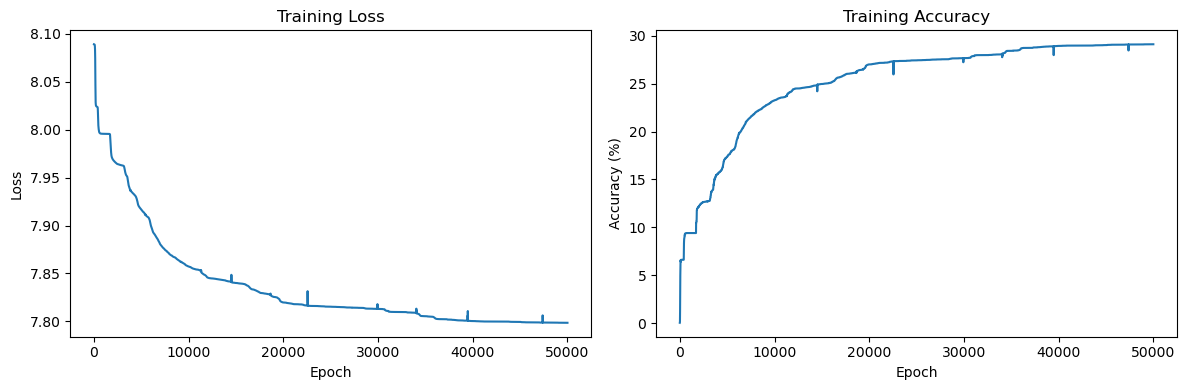


Final Results:
Loss: 7.7986
Accuracy: 29.11%


#### Predict

In [ ]:
initial_text = "you know nothing jon snow"
generated_text = generate_sequence(
    model=model,
    initial_text=initial_text,
    word_dict=word_index,
    sequence_length=max_sequence_len,
    num_words=10,
    device=device
)

print("\nFinal generated sequence:")
print(generated_text)

Initial text: you know nothing jon snow
Using device: cuda

Final generated sequence:
you know nothing jon snow for her as i the little boy mountains of the


### Aggressive optimization

In [13]:
# Initialize the model
model = LSTMPredictor(
    vocab_size, 
    embedding_dim=16, 
    hidden_dim=64, 
    num_layers=2, 
    init_weights=True
    )
model = model.to(device)

#### Train

In [ ]:
# Training setup
criterion = nn.CrossEntropyLoss()

# Much more aggressive learning rate
initial_lr = 0.01

# Using AdamW with weight decay and higher learning rate
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=initial_lr,
    weight_decay=0.01,
    betas=(0.9, 0.999)
)

# More aggressive learning rate scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=initial_lr,
    epochs=20000,
    steps_per_epoch=1,
    pct_start=0.1,  # Quick warmup
    div_factor=10.0,  # Initial lr = max_lr/10
    final_div_factor=1000.0  # Min lr = initial_lr/1000
)

# Lists to store metrics
train_losses = []
train_accuracies = []

# Training loop with accuracy tracking
num_epochs = 20000

# Configure early stopping
best_loss = float('inf')
patience_counter = 0
patience = 1000
min_delta = 0.0001

model.train()
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(xs_tensor)
    loss = criterion(outputs, torch.max(ys_tensor, 1)[1])

    # Calculate accuracy
    _, predicted = torch.max(outputs.data, 1)
    _, targets = torch.max(ys_tensor, 1)

    correct = (predicted == targets).sum().item()
    total = targets.size(0)
    accuracy = 100 * correct / total

    # Store metrics
    train_losses.append(loss.item())
    train_accuracies.append(accuracy)

    # Early stopping check
    if loss.item() < best_loss - min_delta:
        best_loss = loss.item()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping triggered at epoch {epoch+1}')
        break

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()

    # More aggressive gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

    optimizer.step()
    scheduler.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Loss: {loss.item():.4f}, '
              f'Accuracy: {accuracy:.2f}%, '
              f'LR: {scheduler.get_last_lr()[0]:.6f}')
        
# analyse training
plot_training(train_losses, train_accuracies)

Epoch [100/20000], Loss: 6.5509, Accuracy: 6.60%, LR: 0.001055
Epoch [200/20000], Loss: 6.0194, Accuracy: 7.16%, LR: 0.001220
Epoch [300/20000], Loss: 5.5368, Accuracy: 8.33%, LR: 0.001491
Epoch [400/20000], Loss: 4.9256, Accuracy: 10.61%, LR: 0.001860
Epoch [500/20000], Loss: 4.3568, Accuracy: 14.52%, LR: 0.002319
Epoch [600/20000], Loss: 3.7985, Accuracy: 21.21%, LR: 0.002857
Epoch [700/20000], Loss: 3.2255, Accuracy: 31.20%, LR: 0.003459
Epoch [800/20000], Loss: 2.7004, Accuracy: 40.90%, LR: 0.004112
Epoch [900/20000], Loss: 2.2541, Accuracy: 49.13%, LR: 0.004799
Epoch [1000/20000], Loss: 1.9063, Accuracy: 55.90%, LR: 0.005504
Epoch [1100/20000], Loss: 1.6260, Accuracy: 62.17%, LR: 0.006208
Epoch [1200/20000], Loss: 1.5177, Accuracy: 62.73%, LR: 0.006895
Epoch [1300/20000], Loss: 1.2061, Accuracy: 71.19%, LR: 0.007547
Epoch [1400/20000], Loss: 1.1058, Accuracy: 73.20%, LR: 0.008149
Epoch [1500/20000], Loss: 1.0181, Accuracy: 74.68%, LR: 0.008686
Epoch [1600/20000], Loss: 0.8841, Acc

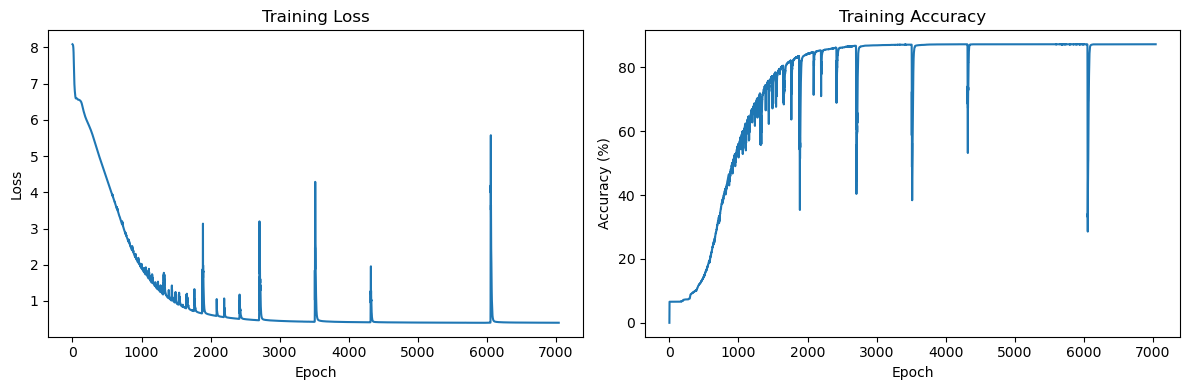


Final Results:
Loss: 0.3981
Accuracy: 87.20%


#### Predict

In [21]:
# Example usage:
initial_text = "you know nothing jon snow"
generated_text = generate_sequence(
    model=model,
    initial_text=initial_text,
    word_dict=word_index,
    sequence_length=max_sequence_len,
    num_words=10,
    device=device
)

print("\nFinal generated sequence:")
print(generated_text)

Initial text: you know nothing jon snow

Final generated sequence:
you know nothing jon snow come to anchor she left me quite notes from tree


## Windowing the data

In [ ]:
# Windowing the data
window_size = 8
sentences = []
alltext = []
data = open(path_data).read()
corpus = data.lower()
words = corpus.split(" ")
range_size = len(words) - max_sequence_len
for i in range(0, range_size):
    thissentence = ""
    for word in range(0, window_size - 1):
        word = words[i + word]
        thissentence = thissentence + word
        thissentence = thissentence + " "
    sentences.append(thissentence)

In [15]:
input_sequences = []
for line in sentences:
    token_list = text_to_sequence(line, word_index)
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, max_sequence_len)
print(len(input_sequences))

83583


In [16]:
xs, labels = split_sequences(input_sequences)
print(len(xs))
print(len(labels))

83583
83583


In [17]:
vocab_size = len(word_index)
ys = []
for y in labels:
  ys.append(one_hot_encode_with_checks(y[0], vocab_size))
print(ys[0])

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 